In [1]:
import os
# Set environment variable
if "ACCEPT_TC" not in os.environ:
    os.environ["ACCEPT_TC"] = "tôi đồng ý"
from datetime import datetime
import pandas as pd
from vnstock3 import Vnstock
import pandas_ta as ta
from prophet import Prophet
import F  # Assuming 'F' is a module you've created
import matplotlib.pyplot as plt

C:\Users\thien\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


In [2]:
# Get current date
now = datetime.now()
current_date = now.strftime("%Y-%m-%d")

# Fetch VN30 and VNI stock data
vn30 = Vnstock().stock(symbol='VN30', source='VCI')
df_vn30 = vn30.quote.history(start='2020-08-01', end=current_date, to_df=True)

vni = Vnstock().stock(symbol='VNINDEX', source='VCI')
df_vni = vni.quote.history(start='2020-08-01', end=current_date, to_df=True)

2024-07-06 14:39:52,285 - vnstock3.common.data.data_explorer - WARNING - Thông tin niêm yết & giao dịch sẽ được truy xuất từ TCBS
2024-07-06 14:39:55,140 - vnstock3.common.data.data_explorer - WARNING - Thông tin niêm yết & giao dịch sẽ được truy xuất từ TCBS


In [3]:
# Function to process data
def process_data(data):
    data['time'] = pd.to_datetime(data['time'])
    data.sort_values(by='time', ascending=True, inplace=True)
    data.reset_index(drop=True, inplace=True)
    
    data['close'] = pd.to_numeric(data['close'], errors='coerce')
    data['sma5'] = ta.sma(data['close'], length=5)
    data['sma10'] = ta.sma(data['close'], length=10)
    data['ema5'] = ta.ema(data['close'], length=5)
    data['ema10'] = ta.ema(data['close'], length=10)
    data['rsi'] = ta.rsi(data['close'], length=14)
    data.ta.macd(close='close', fast=12, slow=26, signal=9, append=True)

    data.dropna(inplace=True)
    data.reset_index(drop=True, inplace=True)
    return data

# Process the VN30 and VNI data
data_VN30 = process_data(df_vn30)
data_VNI = process_data(df_vni)

# Function to train Prophet model
def model_Prophet(data):
    prophet_data = data[['time', 'close']].rename(columns={'time': 'ds', 'close': 'y'})
    model = Prophet(daily_seasonality=True, yearly_seasonality=True, weekly_seasonality=True)
    model.fit(prophet_data)
    return model

# Function to get prediction from Prophet model
def output_Prophet(model, current_time):
    future = pd.DataFrame({'ds': [current_time]})
    forecast = model.predict(future)
    predicted_price = forecast['yhat'].values[0]
    return predicted_price

# Backtesting function
def test(data, k):
    data_output = data[['time', 'close']].copy()
    data_output['position'] = 0

    # Initialize model
    model_prophet = model_Prophet(data)
    
    for i in range(k, len(data)):
        current_time = data.iloc[i]['time']
        
        prophet_pred = output_Prophet(model_prophet, current_time)
        
        predictions = prophet_pred - data.iloc[i-1]['close']
        
        data_output.loc[i, 'position'] = 1 if predictions > 2 else (-1 if predictions < -2 else 0)
    
    data_output.dropna(inplace=True)
    return data_output

# Plotting function for PNL with annotation
def plot_pnl_with_annotation(data, symbol):
    backtesting = F.BacktestInformation(data['time'], data['position'], data['close'])
    pnl_data = backtesting.Plot_PNL(plot=False)
    
    # Plot PNL
    plt.figure(figsize=(15, 6))
    pnl_data['total_gain'].plot(label='Total Gain')
    pnl_data['total_gain_after_fee'].plot(label='Total Gain After Fee')

    plt.title(f'PNL for {symbol}')
    plt.xlabel('Time')
    plt.ylabel('PNL')
    plt.legend()
    plt.grid(True)
    plt.annotate(f'Stock: {symbol}', xy=(0.05, 0.95), xycoords='axes fraction', fontsize=12,
                 bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=1'))
    plt.show()

14:39:58 - cmdstanpy - INFO - Chain [1] start processing
14:39:58 - cmdstanpy - INFO - Chain [1] done processing
14:40:33 - cmdstanpy - INFO - Chain [1] start processing
14:40:33 - cmdstanpy - INFO - Chain [1] done processing


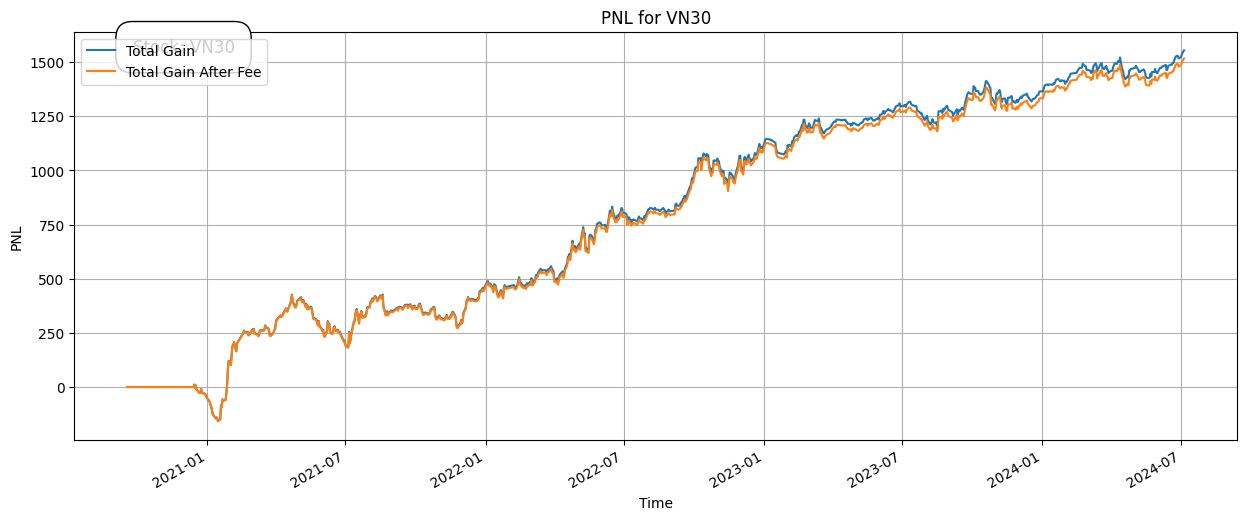

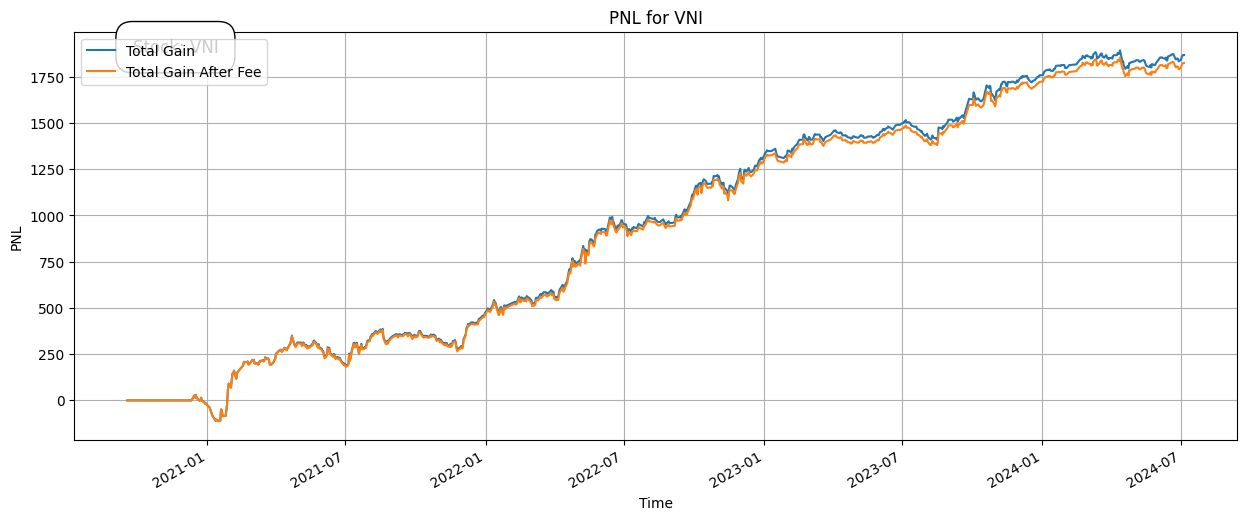

Backtesting Results for VN30
Margin: 68.18746175422092
MDD: (191.98221518987322, 0.12462250500799944)

   Total trading quantity: 90
         Profit per trade: 17.27744444444443
             Total Profit: 1555.0
         Profit after fee: 1517.3
 Trading quantity per day: 0.0949367088607595
 Profit per day after fee: 1.6005274261603375
                   Return: 0.25919304235883606
          Profit per year: 399.2894736842105
                  HitRate: 0.5777777777777777
          HitRate per day: 0.4857444561774023


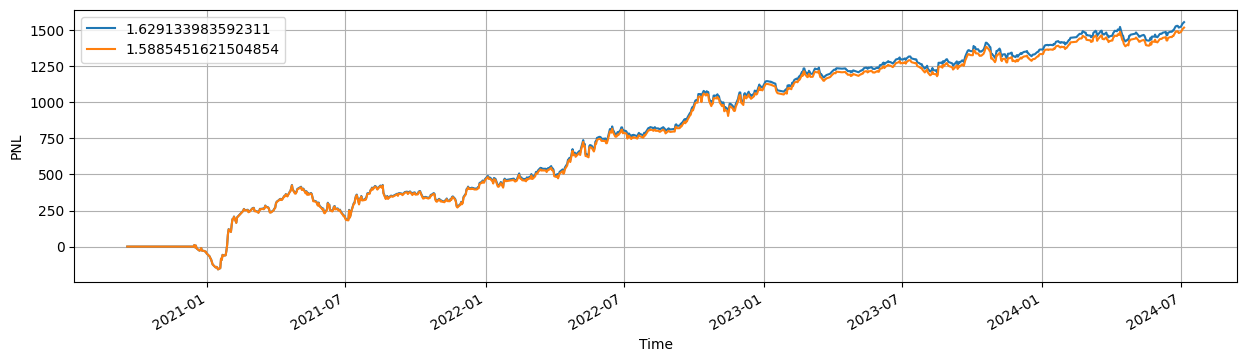

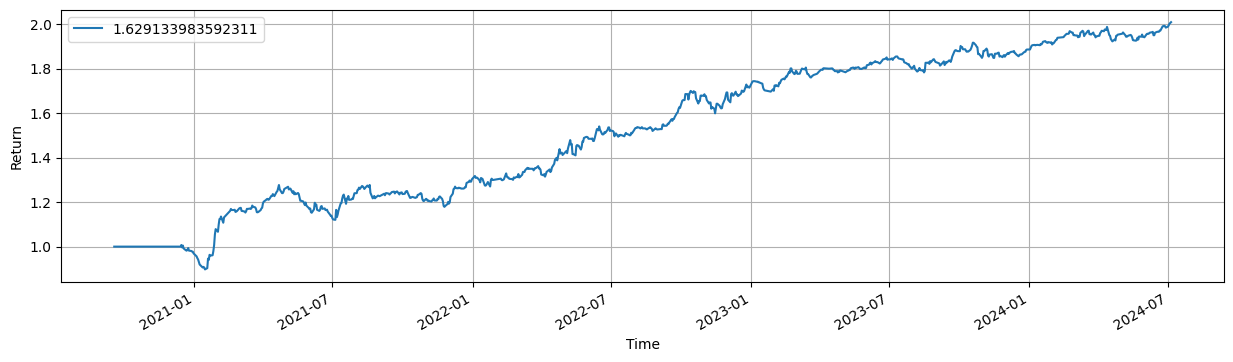

Backtesting Results for VNI
Margin: 75.456175361491
MDD: (109.43999999999983, 0.07320646175457361)

   Total trading quantity: 102
         Profit per trade: 18.312843137254884
             Total Profit: 1867.9
         Profit after fee: 1824.9
 Trading quantity per day: 0.10759493670886076
 Profit per day after fee: 1.925
                   Return: 0.32123940071926366
          Profit per year: 480.2368421052632
                  HitRate: 0.7254901960784313
          HitRate per day: 0.4963041182682154


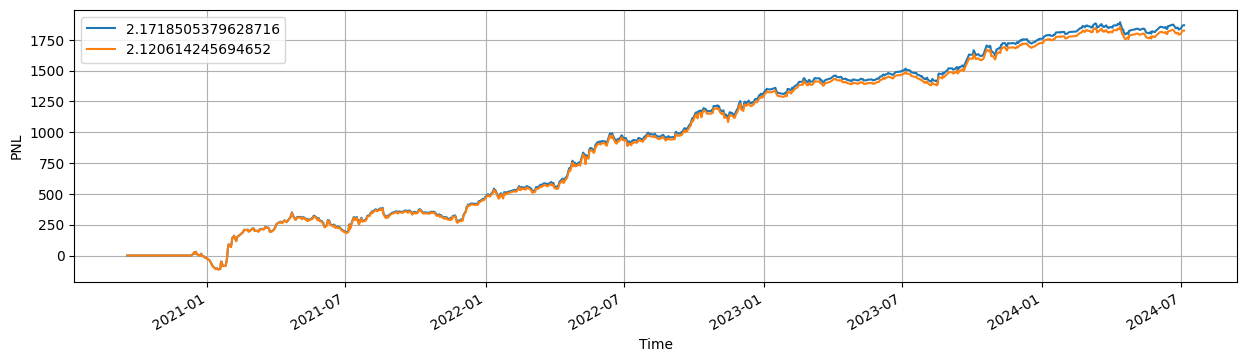

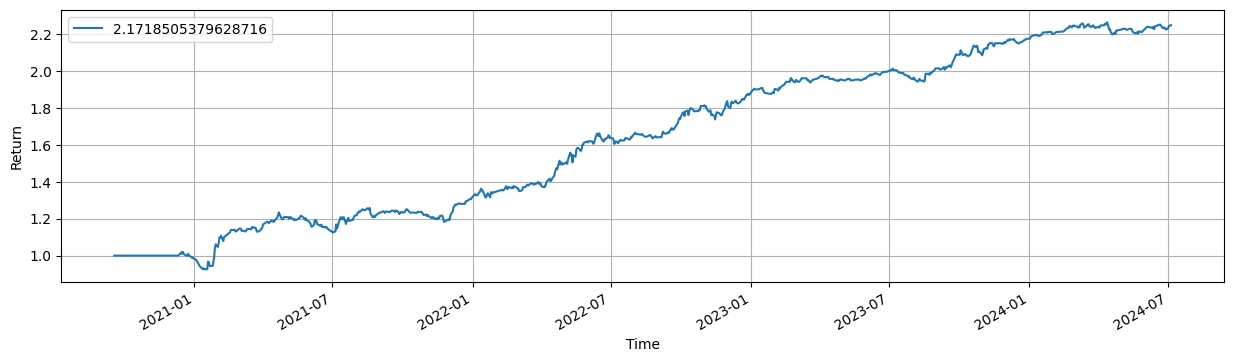

,total_gain,fee,total_gain_after_fee,Position,Close,Return
Datetime,,,,,,
2020-09-18,0.00,0.000000,0.000000,0,900.95,1.000000
2020-09-21,0.00,0.000000,0.000000,0,907.94,1.000000
2020-09-22,0.00,0.000000,0.000000,0,906.19,1.000000
2020-09-23,0.00,0.000000,0.000000,0,912.50,1.000000
2020-09-24,0.00,0.000000,0.000000,0,908.58,1.000000
...,...,...,...,...,...,...
2024-07-01,1842.58,42.578924,1800.001076,1,1254.56,2.232536
2024-07-02,1857.81,42.578924,1815.231076,1,1269.79,2.242724
2024-07-03,1864.87,42.578924,1822.291076,1,1276.85,2.247446


In [4]:
# Run the backtesting for VN30 and VNI
data_VNI_position = test(data_VNI, 60)
data_VN30_position = test(data_VN30, 60)

plot_pnl_with_annotation(data_VN30_position, 'VN30')
plot_pnl_with_annotation(data_VNI_position, 'VNI')

# Print backtesting results
backtesting_VN30 = F.BacktestInformation(data_VN30_position['time'], data_VN30_position['position'], data_VN30_position['close'])
backtesting_VNI = F.BacktestInformation(data_VNI_position['time'], data_VNI_position['position'], data_VNI_position['close'])

print("Backtesting Results for VN30")
backtesting_VN30.Plot_PNL()

print("Backtesting Results for VNI")
backtesting_VNI.Plot_PNL()